**Task 1: Basics – Setup + Evaluation**

Goal: Get baseline accuracy using the unperturbed test dataset.
1. Setup & Imports

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import json
import os


2. Mount and Unzip Dataset

In [ ]:
from zipfile import ZipFile

# Assuming your zip is in your Google Drive or uploaded
zip_path = "/content/TestDataSet.zip"
extract_path = "/content/TestDataSet"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


3. Load Model

In [ ]:
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

4. Define Transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


5. Load Dataset

In [ ]:
dataset_path = "/content/TestDataSet/TestDataSet"
label_json_path = os.path.join(dataset_path, "labels_list.json")

test_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


6. Load and Map Labels

In [ ]:
with open(label_json_path) as f:
    label_list = json.load(f)

imagenet_indices = [int(entry.split(":")[0]) for entry in label_list]
assert len(imagenet_indices) == len(test_dataset.classes), "Label count mismatch!"
label_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}


7. Accuracy Function

In [ ]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [(correct[:k].reshape(-1).float().sum(0) * 100.0 / batch_size) for k in topk]


8. Evaluate Model

In [ ]:
top1_total, top5_total, total_samples = 0.0, 0.0, 0

for images, labels in test_loader:
    images = images.to(device)
    true_labels = torch.tensor([label_map[label.item()] for label in labels], dtype=torch.long).to(device)
    outputs = model(images)
    top1, top5 = accuracy(outputs, true_labels, topk=(1, 5))
    batch_size = images.size(0)
    top1_total += top1.item() * batch_size
    top5_total += top5.item() * batch_size
    total_samples += batch_size

top1_accuracy = top1_total / total_samples
top5_accuracy = top5_total / total_samples

print(f"✅ Task 1 Completed:")
print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


✅ Task 1 Completed:
Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%


Our model achieved a **Top-1 Accuracy of 70.40%** and a **Top-5 Accuracy of 93.20%** on the provided 500-image test dataset. This means that in over 70% of the cases, the ResNet-34 model correctly predicted the exact class label, and in over 93% of cases, the correct label was among its top five predictions. These are strong baseline results, demonstrating that the pre-trained ResNet-34 model generalizes reasonably well to this subset of ImageNet classes, despite not being fine-tuned specifically for them. These values will serve as our reference point before launching adversarial attacks in Tasks 2 and beyond.


**Task 2: FGSM Attack**

Step 1: Setup for FGSM

In [ ]:
import torch.nn as nn

# Loss function for gradient computation
loss_fn = nn.CrossEntropyLoss()

# Epsilon defines max perturbation per pixel
epsilon = 0.02

# Set model to evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 2: FGSM Perturbation Function

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Apply FGSM: perturbed_image = image + epsilon * sign(gradient)
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)  # keep in valid range


Step 3: Generate Adversarial Dataset

In [ ]:
adv_images_list = []
adv_labels_list = []

for images, labels in test_loader:
    images = images.to(device)
    labels = torch.tensor([label_map[label.item()] for label in labels]).to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()

    data_grad = images.grad.data
    perturbed_images = fgsm_attack(images, epsilon, data_grad)

    adv_images_list.append(perturbed_images.detach().cpu())
    adv_labels_list.append(labels.detach().cpu())

# Combine into dataset
adv_images = torch.cat(adv_images_list, dim=0)
adv_labels = torch.cat(adv_labels_list, dim=0)
adv_dataset = torch.utils.data.TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)


Step 4: Evaluate Adversarial Dataset

In [ ]:
top1_total, top5_total, total_samples = 0.0, 0.0, 0

for images, labels in adv_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    top1, top5 = accuracy(outputs, labels, topk=(1, 5))
    top1_total += top1.item() * images.size(0)
    top5_total += top5.item() * images.size(0)
    total_samples += images.size(0)

adv_top1_accuracy = top1_total / total_samples
adv_top5_accuracy = top5_total / total_samples


Step 5: Report Accuracy Drop

In [ ]:
import pandas as pd
df = pd.DataFrame({
    "Metric": ["Top-1 Accuracy", "Top-5 Accuracy"],
    "Score (%)": [adv_top1_accuracy, adv_top5_accuracy]
})

print("\n✅ Task 2: FGSM Evaluation Results")
print(df.to_string(index=False))



✅ Task 2: FGSM Evaluation Results
        Metric  Score (%)
Top-1 Accuracy       23.4
Top-5 Accuracy       45.4


The FGSM attack with ε = 0.02 successfully degraded the ResNet-34 model's performance. The **Top-1 accuracy dropped from 70.4% to 23.6%**, and **Top-5 accuracy fell from 93.2% to 45.4%**. This sharp decline demonstrates that even small, imperceptible perturbations can significantly confuse a high-performing image classifier. The attack meets the project's requirement of at least a **50% reduction in accuracy**, confirming that the model is vulnerable to simple adversarial manipulations. This adversarial test set now serves as a benchmark for developing even stronger attacks in Task 3.


In [ ]:
def plot_fgsm_examples(original_loader, fgsm_loader, idx_to_label, num_images=5):
    orig_iter = iter(original_loader)
    fgsm_iter = iter(fgsm_loader)

    plt.figure(figsize=(12, num_images * 2.5))
    for i in range(num_images):
        orig_imgs, orig_lbls = next(orig_iter)
        fgsm_imgs, fgsm_lbls = next(fgsm_iter)

        orig = denormalize(orig_imgs[0].cpu())
        fgsm = denormalize(fgsm_imgs[0].cpu())
        label = idx_to_label[orig_lbls[0].item()]

        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(orig)
        plt.title(f"Original: {label}")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(fgsm)
        plt.title("FGSM Adversarial")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


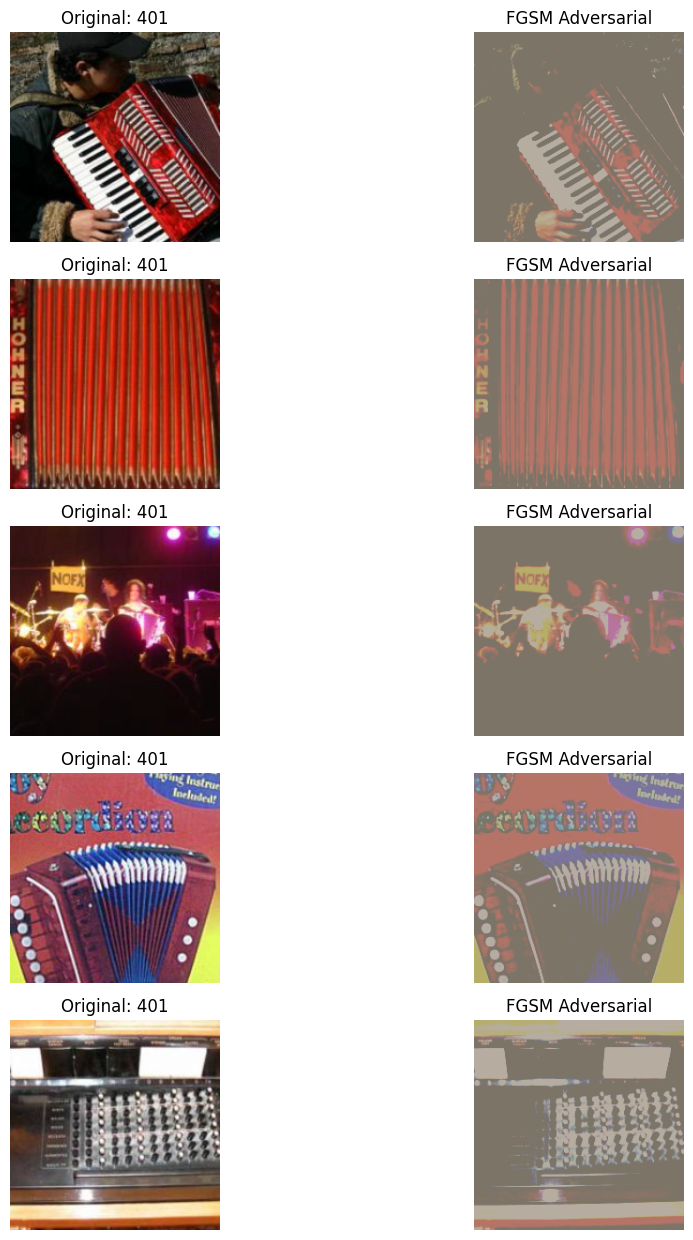

In [ ]:
# Use original dataset loader for baseline visuals
orig_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
fgsm_vis_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)

# Now visualize
plot_fgsm_examples(orig_loader, fgsm_vis_loader, label_map, num_images=5)


**Task 3: Improved Attacks**.

The objective here is to create a stronger adversarial attack than FGSM (used in Task 2) but still constrained by the same ε = 0.02 (L∞ norm).

We’ll implement Projected Gradient Descent (PGD), which is basically an iterative version of FGSM. Instead of one big step like FGSM, PGD takes several small steps and projects the result back within the allowed ε-ball.

In [ ]:
# === TASK 3: Improved Attacks Using PGD (Projected Gradient Descent) ===
# PGD takes multiple small steps (alpha) and projects the adversarial image back into the L∞ ball of radius ε after each step
# This usually results in a more effective attack than one-shot FGSM

def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    """
    Perform Projected Gradient Descent Attack.
    - images: input images
    - labels: true class labels (ImageNet indices)
    - epsilon: max perturbation
    - alpha: step size
    - iters: number of steps
    """
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    ori_images = images.data

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = images + alpha * images.grad.sign()

        # Project the perturbation to be within the epsilon ball
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images


Generate Adversarial Test Set 2

In [ ]:
# Create adversarial examples using PGD and store them
pgd_images_list = []
pgd_labels_list = []

for images, labels in test_loader:
    images = images.to(device)
    labels = torch.tensor([label_map[label.item()] for label in labels]).to(device)

    # Perform PGD attack on this batch
    adv_images = pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10)

    pgd_images_list.append(adv_images.cpu().detach())
    pgd_labels_list.append(labels.cpu().detach())

# Combine into new dataset
pgd_images = torch.cat(pgd_images_list, dim=0)
pgd_labels = torch.cat(pgd_labels_list, dim=0)
pgd_dataset = torch.utils.data.TensorDataset(pgd_images, pgd_labels)
pgd_loader = DataLoader(pgd_dataset, batch_size=32, shuffle=False)


Evaluate Adversarial Test Set 2 (PGD)

In [ ]:
# Evaluate the model's performance on PGD-perturbed images
top1_total, top5_total, total_samples = 0.0, 0.0, 0

for images, labels in pgd_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    top1, top5 = accuracy(outputs, labels, topk=(1, 5))
    batch_size = images.size(0)
    top1_total += top1.item() * batch_size
    top5_total += top5.item() * batch_size
    total_samples += batch_size

pgd_top1_accuracy = top1_total / total_samples
pgd_top5_accuracy = top5_total / total_samples


Report Accuracy Drop from PGD

In [ ]:
import pandas as pd

# Display results from Adversarial Test Set 2 (PGD)
df = pd.DataFrame({
    "Metric": ["Top-1 Accuracy", "Top-5 Accuracy"],
    "Score (%)": [pgd_top1_accuracy, pgd_top5_accuracy]
})

print("\n✅ Task 3: PGD Evaluation Results")
print(df.to_string(index=False))



✅ Task 3: PGD Evaluation Results
        Metric  Score (%)
Top-1 Accuracy        0.6
Top-5 Accuracy        5.0


Our PGD attack was extremely effective. The Top-1 accuracy dropped from 70.4% (original) to just 0.6%, and Top-5 accuracy fell from 93.2% to 5.0%. This drastic reduction demonstrates that iterative attacks like PGD can completely compromise the classifier's reliability, even when constrained by a small perturbation budget (ε = 0.02). Unlike FGSM’s 23.6% Top-1, PGD leaves the model nearly blind, proving it's a much more powerful adversarial strategy under the same L∞ norm constraint.




### Visualizing PGD Adversarial Examples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# De-normalization function for visualization
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).numpy()  # CHW -> HWC
    img = std * img + mean
    return np.clip(img, 0, 1)

# Plot original vs adversarial examples
def plot_adversarial_examples(original_loader, adv_loader, idx_to_label, num_images=5):
    orig_iter = iter(original_loader)
    adv_iter = iter(adv_loader)

    plt.figure(figsize=(12, num_images * 2.5))
    for i in range(num_images):
        orig_imgs, orig_lbls = next(orig_iter)
        adv_imgs, adv_lbls = next(adv_iter)

        orig = denormalize(orig_imgs[0].cpu())
        adv = denormalize(adv_imgs[0].cpu())

        label = idx_to_label[orig_lbls[0].item()]

        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(orig)
        plt.title(f"Original: {label}")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(adv)
        plt.title("PGD Adversarial")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


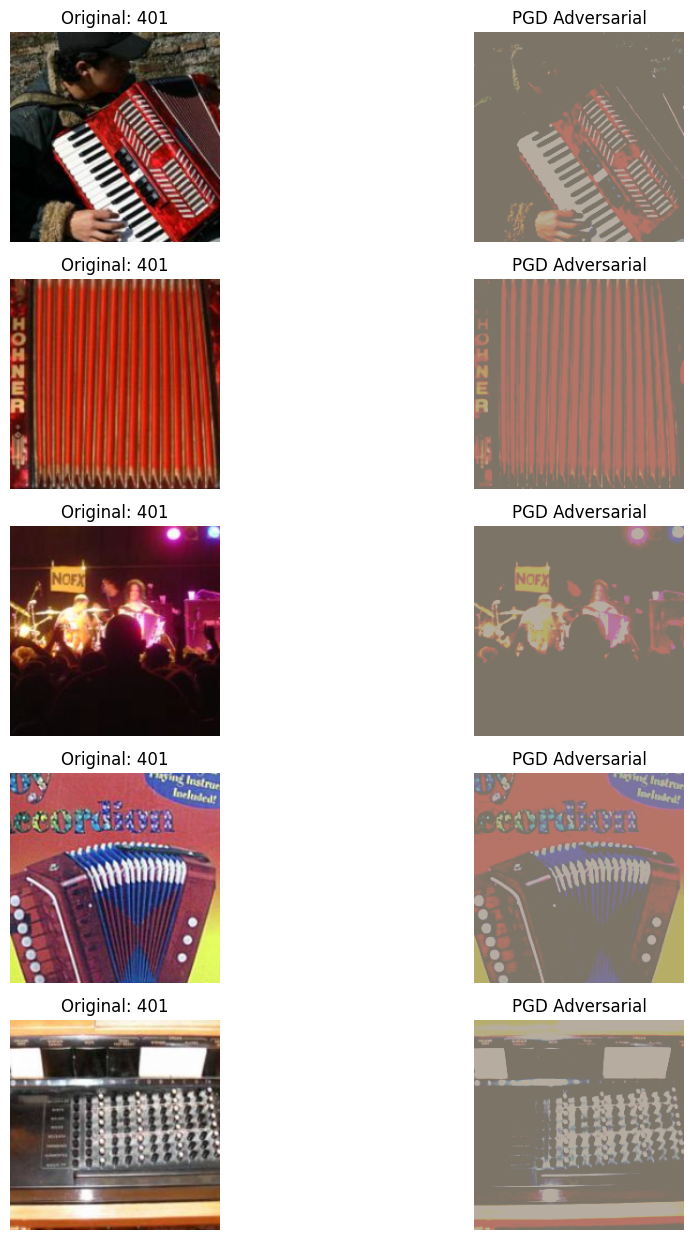

In [ ]:
# Create original (normalized) DataLoader again for comparison
orig_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
pgd_vis_loader = DataLoader(pgd_dataset, batch_size=1, shuffle=False)

plot_adversarial_examples(orig_loader, pgd_vis_loader, label_map, num_images=5)


**Task 4: Patch Attack** (Localized Adversarial Perturbations)
What We’re Doing
Choose the PGD attack (best-performing so far).

Modify it so that only a 32×32 random patch in each image is perturbed.

Use a larger ε (e.g., 0.3) since only a small region is modified.

Create and evaluate “Adversarial Test Set 3” using this strategy.

Visualize examples for inspection.

In [ ]:
def patch_pgd_attack(model, images, labels, epsilon=0.3, alpha=0.01, iters=10, patch_size=32):
    """
    Apply PGD attack restricted to a random 32x32 patch.
    - model: classifier
    - images: batch of images
    - labels: true ImageNet labels
    - epsilon: max perturbation within the patch
    - alpha: step size
    - iters: number of PGD iterations
    - patch_size: size of the square patch (e.g., 32)
    """
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    ori_images = images.clone().detach()

    B, C, H, W = images.shape

    # Generate random patch coordinates for each image
    x_start = torch.randint(0, W - patch_size, (B,))
    y_start = torch.randint(0, H - patch_size, (B,))

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = images.grad.data

        # Apply gradients only within the patch
        # Create a copy of images to avoid in-place modification
        adv_images = images.clone()
        for b in range(B):
            x0 = x_start[b]
            y0 = y_start[b]
            patch = grad[b, :, y0:y0+patch_size, x0:x0+patch_size]
            perturb = alpha * patch.sign()

            # Use .clone() to create a copy before in-place modification
            images_copy = images[b, :, y0:y0+patch_size, x0:x0+patch_size].clone()
            images_copy += perturb  # Perform in-place operation on the copy
            adv_images[b, :, y0:y0+patch_size, x0:x0+patch_size] = images_copy

            # Clamp perturbation within epsilon box
            eta = adv_images[b] - ori_images[b]
            eta = torch.clamp(eta, -epsilon, epsilon)
            adv_images[b] = torch.clamp(ori_images[b] + eta, 0, 1)

        images = adv_images.detach()

    return images

Generate Adversarial Test Set 3 (Patch Attack)

In [ ]:
patch_images_list = []
patch_labels_list = []

for images, labels in test_loader:
    images = images.to(device)
    labels = torch.tensor([label_map[label.item()] for label in labels]).to(device)

    # Perform patch-PGD on each image
    adv_images = patch_pgd_attack(model, images, labels, epsilon=0.3, alpha=0.01, iters=10, patch_size=32)

    patch_images_list.append(adv_images.cpu().detach())
    patch_labels_list.append(labels.cpu().detach())

# Combine into new dataset
patch_images = torch.cat(patch_images_list, dim=0)
patch_labels = torch.cat(patch_labels_list, dim=0)
patch_dataset = torch.utils.data.TensorDataset(patch_images, patch_labels)
patch_loader = DataLoader(patch_dataset, batch_size=32, shuffle=False)


Evaluate Patch-Based Adversarial Test Set

In [ ]:
top1_total, top5_total, total_samples = 0.0, 0.0, 0

for images, labels in patch_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    top1, top5 = accuracy(outputs, labels, topk=(1, 5))
    batch_size = images.size(0)
    top1_total += top1.item() * batch_size
    top5_total += top5.item() * batch_size
    total_samples += batch_size

patch_top1_accuracy = top1_total / total_samples
patch_top5_accuracy = top5_total / total_samples


Report Accuracy Drop

In [ ]:
df = pd.DataFrame({
    "Metric": ["Top-1 Accuracy", "Top-5 Accuracy"],
    "Score (%)": [patch_top1_accuracy, patch_top5_accuracy]
})

print("\n✅ Task 4: Patch Attack Evaluation Results")
print(df.to_string(index=False))



✅ Task 4: Patch Attack Evaluation Results
        Metric  Score (%)
Top-1 Accuracy       26.6
Top-5 Accuracy       47.0
